In [49]:
import torch
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version reported by torch:", torch.version.cuda)
print("Device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Device 0:", torch.cuda.get_device_name(0))

Torch: 2.6.0+cu124
CUDA available: True
CUDA version reported by torch: 12.4
Device count: 1
Device 0: NVIDIA GeForce RTX 4070 Laptop GPU


In [50]:
from tqdm import tqdm

import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    # Expects input images of size (3, 224, 224)
    def __init__(self, num_classes=7):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(8)
        self.conv4 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(8 * 56 * 56, 32)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.softmax(self.fc2(x), dim=1)
        return x

def train_cnn(model, dataloader, criterion, optimizer, device, num_epochs=10):
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        progress_bar = tqdm(dataloader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            progress_bar.set_postfix(loss=running_loss/(progress_bar.n+1))
        # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")


    




Classes: ['bernese_mountain_dog', 'border_collie', 'chihuahua', 'golden_retriever', 'labrador', 'pug', 'siberian_husky']
Classes: ['bernese_mountain_dog', 'border_collie', 'chihuahua', 'golden_retriever', 'labrador', 'pug', 'siberian_husky']


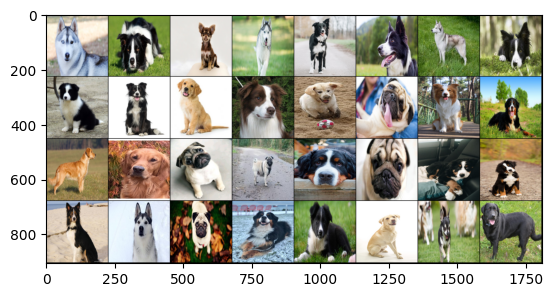

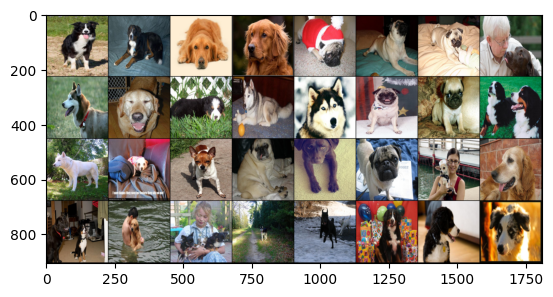

In [51]:
# Test loader is dog-breed-images
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader

test_set_path = "dog-breed-images/"
train_set_path = "stanford-dogs-dataset/images/"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
test_dataset = datasets.ImageFolder(root=test_set_path, transform=transform)
# print class names
print("Classes:", test_dataset.classes)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Train loader is standford-dogs-dataset
train_dataset = datasets.ImageFolder(root=train_set_path, transform=transform)
print("Classes:", train_dataset.classes) # print class names

# apply data augmentation to train dataset
# train_dataset.transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(10),
#     transforms.ToTensor(),
# ])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


# visualize a batch of images
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# visualize a batch of test data
test_images, test_labels = next(iter(test_loader))
imshow(utils.make_grid(test_images))

# visualize a batch of train data
train_images, train_labels = next(iter(train_loader))
imshow(utils.make_grid(train_images))

def test_model(model, test_loader, device):
    # Test the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Test Accuracy: {100 * correct / total:.2f}%')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [52]:

# Define criterion and optimizer
model = SimpleCNN(num_classes=len(train_dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training loop
epochs = 10
train_cnn(model, train_loader, criterion, optimizer, device, num_epochs=epochs)

# Test the model
test_model(model, test_loader, device)


Epoch [1/10]:   0%|          | 0/39 [00:00<?, ?it/s]

Test Accuracy: 34.21%


In [53]:
# Same as above, but without dropout

class SimpleCNN2(nn.Module):
    def __init__(self, num_classes=7):
        super(SimpleCNN2, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(8)
        self.conv4 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(8 * 56 * 56, 32)
        self.fc2 = nn.Linear(32, num_classes)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

# Define criterion and optimizer
model = SimpleCNN2(num_classes=len(train_dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)


## Part 2 Task I

To compare the two datasets, first visualize a few sample images from each. Observe aspects such as image resolution, background complexity, dog pose, and annotation quality. Systematic differences may include:

- **Stanford Dogs Dataset**: Typically features higher-resolution images, varied backgrounds, and dogs in natural settings. Images may have more challenging backgrounds and diverse poses.
- **Dog Breed Images Dataset**: May contain more standardized images, sometimes with simpler backgrounds or studio-like settings. The annotation style and cropping may differ.

Briefly document any consistent differences you notice, as these can impact model training and generalization.

## Task 3: ResNet training
a) In this task, we use the ResNet-18 model for the classification of the images in the DBI dataset. To do so, use the ResNet-18 model from PyTorch, modify the input/output layers to match your dataset, and train the model from scratch; i.e., do not use the pre- trained ResNet. Plot the training and validationaccuracy and report the final test results, and compare those with the results of your CNN model.

b) Run the trained model on the entire SDD dataset and report the accuracy. Compare the accuracy obtained on the (test set of) DBI, vs. the accuracy obtained on the SDD. Which is higher? Why do you think that might be? Explain very briefly, in one or two sentences.

In [54]:
import torchvision.models as models

# Load an untrained ResNet-18 model
resnet18_untrained = models.resnet18(pretrained=False)

# modify the final layer to match the number of classes in your dataset
num_ftrs = resnet18_untrained.fc.in_features
resnet18_untrained.fc = nn.Linear(num_ftrs, len(train_dataset.classes))

resnet_model = resnet18_untrained.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.001, weight_decay=1e-5)
epochs = 10
train_cnn(resnet_model, train_loader, criterion, optimizer, device, num_epochs=epochs)
test_model(resnet_model, test_loader, device)

Test Accuracy: 34.83%
